# Построение и оптимизация модели

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import matthews_corrcoef
from sklearn import feature_selection, model_selection
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
import imblearn
from imblearn.pipeline import Pipeline
from imblearn import under_sampling
from sklearn.utils import class_weight
import xgboost as xgb
from sklearn.svm import LinearSVC
import pickle

In [3]:
import matplotlib
from matplotlib import pyplot as plt

In [4]:
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
print(imblearn.__version__)
print(xgb.__version__)

1.2.3
1.20.1
0.24.2
0.7.0
1.3.0


In [5]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [6]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [7]:
X = pd.read_csv('orange_small_churn_data.train')
y = pd.read_csv('orange_small_churn_labels.train', header=None).replace(-1, 0)

### 1. Предобработка данных

In [8]:
# Списки числовых и категориальных признаков
numeric_vars, categor_vars = X.loc[:,:'Var190'].columns, X.loc[:,'Var191':].columns

# Трансформер для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())])

# Класс для получения словаря
class Dictifier(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).to_dict('records')

# Класс для отбора категориальных признаков
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.n_features = 2000 # Число признаков для отбора

    def fit(self, X, y):
        # Корреляция Мэтьюса
        self.MCC = np.apply_along_axis(matthews_corrcoef, 0, X, y)
        # Индексы в порядке убывания корреляции
        self.indices = np.argsort(np.absolute(self.MCC))[::-1] 
        return self

    def transform(self, X):
        return X[:,self.indices[:self.n_features]]

# Трансформер для категориальных признаков
categor_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('dictifier', Dictifier()),
    ('vectorizer', DictVectorizer(sparse=False)),
    ('selector', FeatureSelector())])

# Объединение числовых и категориальных признаков
preprocessor = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_vars),
    ('categor_transformer', categor_transformer, categor_vars)])

In [9]:
X_train = preprocessor.fit_transform(X, y)

In [10]:
X_train.tofile('churn_data_2000_features.train', sep=',')

### 2. Undersampling

In [11]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)

undersampling_list = [
    under_sampling.OneSidedSelection,
    under_sampling.TomekLinks,
    under_sampling.NeighbourhoodCleaningRule]

for sampler in undersampling_list:
    
    pipeline = Pipeline(steps=[('sampler', sampler()), ('estimator', lsvc)])
    
    start_time = timer(None)
    print(sampler)
    print('ROC-AUC: {}'.format(cross_val_score(
        pipeline, X_train, y, scoring='roc_auc', cv=skf, n_jobs=-1).mean()))
    timer(start_time)

<class 'imblearn.under_sampling._prototype_selection._neighbourhood_cleaning_rule.NeighbourhoodCleaningRule'>
ROC-AUC: 0.6841031375474785
Time taken: 0 hours 5 minutes and 39.83 seconds.
<class 'imblearn.under_sampling._prototype_selection._one_sided_selection.OneSidedSelection'>
ROC-AUC: 0.6830967767494718
Time taken: 0 hours 10 minutes and 43.92 seconds.
<class 'imblearn.under_sampling._prototype_selection._tomek_links.TomekLinks'>
ROC-AUC: 0.6835721121219863
Time taken: 0 hours 5 minutes and 7.4 seconds.
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'>
ROC-AUC: 0.6760433928058693
Time taken: 0 hours 0 minutes and 6.85 seconds.


### 3. Отбор признаков

In [9]:
X = np.fromfile('churn_data_2000_features.train', sep=',')
y = pd.read_csv('orange_small_churn_labels.train', header=None).replace(-1, 0).values

X = X.reshape(y.size, X.size//y.size)
X_train, y_train = under_sampling.NeighbourhoodCleaningRule().fit_resample(X, y)

In [12]:
%%time
param_grid = {'C': np.linspace(0.06, 0.14, 9),
              'class_weight': [{1: 7, 0: 1},
                               {1: 6.5, 0: 1},
                               {1: 6, 0: 1},
                               {1: 5.5, 0: 1},
                               {1: 5, 0: 1}]}
    
lsvc = LinearSVC(penalty="l1", dual=False)

grid_search = GridSearchCV(lsvc, param_grid, scoring='roc_auc', n_jobs=-1, cv=skf)

grid_search.fit(X_train, y_train)
print('Best params: {} ROC-AUC: {}'.format(grid_search.best_params_, grid_search.best_score_))

selector = SelectFromModel(grid_search.best_estimator_, prefit=True)
selector.transform(X_train)

important_features = selector.get_support(indices=True)
print('Features selected: {}'.format(important_features.size))

Best params: {'C': 0.11000000000000001, 'class_weight': {1: 6, 0: 1}} ROC-AUC: 0.7270592387358169
Features selected: 2593
CPU times: user 20.5 s, sys: 1.18 s, total: 21.7 s
Wall time: 16min 52s


In [12]:
with open('important_features.txt', 'w') as fout:
    fout.write(' '.join(map(str, important_features)))

In [12]:
X_train = X_train[:,important_features]

### 4. Обучение модели

In [28]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
cv = []
alpha_list = np.linspace(0.1, 0.18, 9)

for alpha in alpha_list:
    cv.append(xgb.cv(params={'learning_rate': alpha, 
                             'objective': 'binary:logistic', 
                             'eval_metric': 'logloss',
                             'booster': 'gbtree'},
                     dtrain=dtrain, 
                     num_boost_round=1000, 
                     early_stopping_rounds=50, 
                     nfold=5, 
                     metrics=['auc'], 
                     stratified=True, seed=1))

CPU times: user 3h 44min 42s, sys: 36.7 s, total: 3h 45min 19s
Wall time: 39min 9s


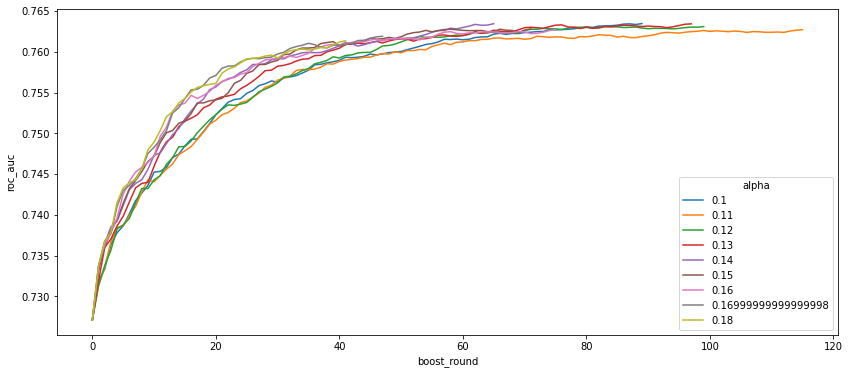

In [29]:
fig = plt.figure(figsize=(14,6))

for n, res in enumerate(cv):
    plt.plot(res[['test-auc-mean']], label=str(alpha_list[n]))
    plt.xlabel('boost_round')
    plt.ylabel('roc_auc')
    plt.legend(title='alpha')

In [11]:
%%time
xgb_clf = xgb.XGBClassifier(learning_rate=0.14, n_estimators=66, objective='binary:logistic', 
                            eval_metric='logloss', booster='gbtree', nthread=-1)

params = {
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.5, 1, 1.5, 2, 2.5],
    'subsample': [0.6, 0.8, 1.0, 1.2],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 6]}

param_comb = 200

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-1, cv=skf, random_state=1)

random_search.fit(X_train, y_train)
print('Best params: {} ROC-AUC: {}'.format(random_search.best_params_, random_search.best_score_))

Best params: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.4} ROC-AUC: 0.7667039377119638
CPU times: user 1min 42s, sys: 698 ms, total: 1min 43s
Wall time: 5h 17min 30s


In [12]:
pickle.dump(random_search.best_estimator_, open('lsvc_xgb_churn_model.pkl', 'wb'))

### 5. Submission to Kaggle

In [9]:
categor_transformer = pickle.load(open('categor_transformer.pkl', 'rb'))
churn_model = pickle.load(open('lsvc_xgb_churn_model.pkl', 'rb'))

In [10]:
with open('important_features.txt', 'r') as fin:
    important_features = list(map(int, fin.readline().split()))

In [12]:
X_test = pd.read_csv('orange_small_churn_test_data.csv')

X_test = np.hstack((numeric_transformer.fit_transform(X_test[numeric_vars]), 
                    categor_transformer.transform(X_test[categor_vars])))

X_test = X_test[:,important_features]

In [14]:
y_score = churn_model.predict_proba(X_test)[:,1]

In [15]:
pd.DataFrame(y_score).reset_index().to_csv('submission.csv', index=False, header=('Id','result'))

ROC-AUC: 0.71583